**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### **Introducción al Aprendizaje Profundo**
### Trabajo Práctico I

---

**Integrantes:** Mara C. Avendaño, Enzo Manolucos, Silvia Ojeda y José Zerda

## Introducción 

El presente trabajo tiene como objetivo implementar una red neuronal para predecir la presencia o ausencia de diabetes en personas, utilizando un dataset que contiene diversos indicadores médicos. A lo largo del trabajo, se explorarán diferentes enfoques, comenzando por un análisis preliminar del dataset. Posteriormente, se implementará una red neuronal simple como baseline, y finalmente se llevará a cabo una búsqueda de hiperparámetros para mejorar los resultados obtenidos.

### Paquetes de Python y Setup

In [63]:
# Importación de librerías de análisis de datos y visualización
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Importación de librerías de aprendizaje automático
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importación de librerías de preprocesamiento de datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Importación de librerías de utilidades
import tqdm

# Configuración de Pandas
pd.set_option('display.max_columns', None)

# Configuración de Matplotlib
%matplotlib inline

# Configuración de la semilla
seed = 27

In [64]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cpu


### Lectura del dataset

BRFSS (Behavioral Risk Factor Surveillance System) es una encuesta telefónica relacionada con la salud que se realiza anualmente por los CDC (Centros para Control y prevención de Enfermedades) desde 1984. Cada año, recoge respuestas de más de 400,000 estadounidenses sobre comportamientos de riesgo, enfermedades crónicas y uso de servicios preventivos. Para este proyecto, se utilizó un dataset de [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv) correspondiente al año 2015. Contiene 70.692 respuestas y 21 variables. La variable objetivo, Diabetes_binary, tiene 2 clases: 0 para no diabetes, y 1 para prediabetes o diabetes.

In [65]:
path_dataset = '../Data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data = pd.read_csv(path_dataset)
data.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0  26.0     0.0     0.0   
1              0.0     1.0       1.0        1.0  26.0     1.0     1.0   
2              0.0     0.0       0.0        1.0  26.0     0.0     0.0   
3              0.0     1.0       1.0        1.0  28.0     1.0     0.0   
4              0.0     0.0       0.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           1.0     0.0      1.0                0.0   
1                   0.0           0.0     1.0      0.0                0.0   
2                   0.0           1.0     1.0      1.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0          0.0      3.0       5.0      30.0       0.0  1.0   
1            1.0          0.0      3.0       0.0       0.0       0.0  1.0   
2            1.0          0.0      1.0       0.0      10.0       0.0  1.0   
3            1.0          0.0      3.0       0.0       3.0       0.0  1.0   
4            1.0          0.0      2.0       0.0       0.0       0.0  0.0   

    Age  Education  Income  
0   4.0        6.0     8.0  
1  12.0        6.0     8.0  
2  13.0        6.0     8.0  
3  11.0        6.0     8.0  
4   8.0        5.0     8.0

## Análisis y exploración de datos (EDA)

Para la explorar los datos se utiliza `ydata_profiling`. Esta librería automatiza y estandariza la generación de informes detallados, completos con estadísticas y visualizaciones.

In [66]:
profile = ProfileReport(data, title='Data Report', progress_bar=False)
profile.to_notebook_iframe()

### Resúmen del dataset

A partir del reporte generado, se pueden sacar las siguientes conclusiones: 

- El conjunto de datos tiene 70.706 filas y 22 columnas (incluida la variable objetivo), de las cuales
    - Categóricas: 16
    - Numéricas: 6
- No hay datos faltantes 
- Diabetes_binary (target) se encuentra perfectamente balanceada
- Stroke, HvyAlcoholConsump, CholCheck, y AnyHealthcare muestran desbalances considerables
- GenHlth y DiffWalk muestran alta correlación
- BMI tiene un promedio de 29,86 y un rango de 12 a 98
- MentHlth y PhysHlth tienen un gran número de ceros

En general, el conjunto de datos parece tener una estructura relativamente simple, con algunas columnas categóricas y numéricas que requieren una mayor atención debido a su desequilibrio o correlación.

### Preparación de los datos

Antes de implementar la red neuronal, se deben separar los datos en entrenamiento, validación y test. Primero se separan las todas las variables de la variable objetivo.

In [67]:
# Separar X e y
X = data.drop('Diabetes_binary',axis=1).values
y = data['Diabetes_binary'].values 

Mediante el método `train_test_split()` se dividen el conjunto de datos en:
- Entranamiento: 70%
- Validación: 15%
- Test: 15%

In [68]:
# Dividir el conjunto en conjuntos de entrenamiento, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

Con los datos ya separados, se escalan los datos mediante `MinMaxScaler()` ya que se requiere que todos los datos esten dentro de un rango específico. Los valores de todos los datos quedaran entre un rango de 0 y 1. Para las variables cuyos valores sean 0 y 1, no es necesario aplicar este escalado, ya que se aplica 

\begin{equation}
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
\end{equation}

Como 

\begin{align}
X_{\text{min}} &= 0 \\
X_{\text{max}} &= 1
\end{align}


El resultado es
\begin{align}
X_{scaled} = X
\end{align}



In [69]:
# Escalar los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

Una vez escalados los datos, se convierten los datos de entrenamiento, validación y test en tensores de PyTorch mediante `Tensor()`. Los datos de salida se convierten en tensores de tipo `LongTensor` y se agregan una dimensión adicional con `unsqueeze(1)`. Luego, se convierten a tipo float.

In [70]:
# Convertir los datos a tensores
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train).unsqueeze(1).float()

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val).unsqueeze(1).float()

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test).unsqueeze(1).float()

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
# Formar el conjuntos de entrenamiento, validación y test en tensores
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([49484, 21]),
 torch.Size([49484, 1]),
 torch.Size([10604, 21]),
 torch.Size([10604, 1]),
 torch.Size([10604, 21]),
 torch.Size([10604, 1]))

Se envían los datos de entrenamiento, validación y prueba a la GPU (si está disponible) utilizando el método `to()`

In [72]:
# Enviar los datos a la GPU (si está disponible)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Función de entrenamiento y validación 

Se crea una función `entrenar_modelo`, la cual entrena el modelo calculando las perdidas y precisición a lo largo de las épocas 

In [73]:
def entrenar_modelo(modelo, X_train, y_train, X_val, y_val, epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm.trange(epochs):
        optimizer.zero_grad()
        y_pred = modelo.forward(X_train)
        loss_train = criterion(y_pred, y_train)
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train.item())

        y_pred_labels = (y_pred >= 0.5).float()
        correct = (y_pred_labels == y_train).sum().item()
        total = len(y_train)
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        #if epoch % 10 == 0:
        #    print(f'epoch: {epoch:2}  loss: {loss_train.item():10.8f}')

        with torch.no_grad():
            y_pred_val = modelo.forward(X_val)
            loss_val = criterion(y_pred_val, y_val)
            val_losses.append(loss_val.item())

            # Calcula la precisión
            y_pred_labels = (y_pred_val >= 0.5).float()
            correct = (y_pred_labels == y_val).sum().item()
            total = len(y_val)
            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)          

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('Función de pérdida a lo largo las épocas')
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.ylabel('Pérdida')
    plt.xlabel('Épocas')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Precisión (Accuracy) a lo largo las épocas')
    plt.plot(train_accuracies, label='Entrenamiento')
    plt.plot(val_accuracies, label='Validación')
    plt.ylabel('Precisión (%)')
    plt.xlabel('Épocas')
    plt.legend()    

    y_pred = modelo.forward(X_val)   
    y_pred_class = (y_pred >= 0.5).float() # Convierte las predicciones a etiquetas (0 o 1)
    print('Validación:')
    report = classification_report(y_val, y_pred_class)

    print(report)

## Red Neuronal (Baseline)

Como baseline se utiliza una red neuronal implementada mediante Keras. Se construye mediante los siguientes parámetros: 

- Entradas: 21
- Cantidad de capas: 2
- Neuronas por capas: 32 y 16 
- Salidas: 1
- Funcion de activación
    - Capas ocultas: Relu
    - Capa de salids: Sigmoid

Luego se compila con el objetivo de mejorar la métrica. El modelo cuenta con el optimizador Adam y la función de pérdida de entropía cruzada binaria. Finalmente se entrena el modelo

In [74]:
# Construir la red neuronal con parámetros por defecto
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta con 32 neuronas
    Dense(16, activation='relu'),  # Capa oculta con 16 neuronas
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo (baseline)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val)) # Se utiliza como datos de valiación los separados anteriormente

Epoch 1/20


c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1547/1547 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7006 - loss: 0.5780 - val_accuracy: 0.7363 - val_loss: 0.5329
Epoch 2/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7459 - loss: 0.5153 - val_accuracy: 0.7442 - val_loss: 0.5208
Epoch 3/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7485 - loss: 0.5113 - val_accuracy: 0.7442 - val_loss: 0.5161
Epoch 4/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7481 - loss: 0.5103 - val_accuracy: 0.7437 - val_loss: 0.5134
Epoch 5/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7502 - loss: 0.5068 - val_accuracy: 0.7461 - val_loss: 0.5129
Epoch 6/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7520 - loss: 0.5042 - val_accuracy: 0.7442 - val_loss: 0.5157
Epoch 7/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7534 - loss: 0.5044 - val_accuracy: 0.7476 - val_loss: 0.5116
Epoch 8/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7536 - loss: 0.5022 - val_accurac

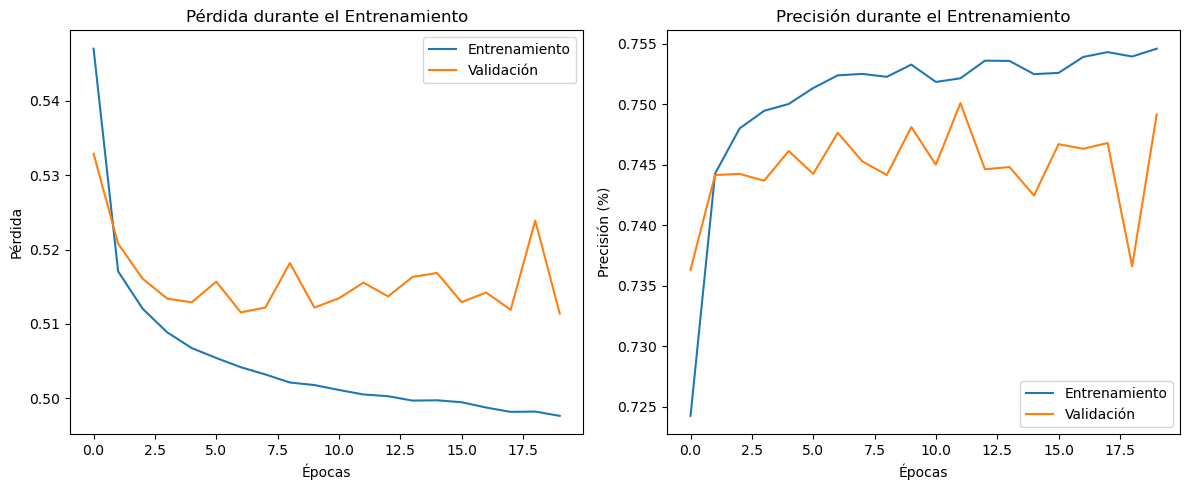

In [75]:
# Pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Función de pérdida a lo largo las épocas')
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.title('Precisión (Accuracy) a lo largo las épocas')
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
y_pred = model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype(int) # Convierte las predicciones a etiquetas (0 o 1)
 
print('Validación:')
report = classification_report(y_val, y_pred_class)
print(report)

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
Validación:
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73      5307
         1.0       0.72      0.81      0.76      5297

    accuracy                           0.75     10604
   macro avg       0.75      0.75      0.75     10604
weighted avg       0.75      0.75      0.75     10604



Definiremos a continuación una función llamada `build_model` que toma un argumento hp, que es una instancia de Keras Tuner que permite la búsqueda de hiperparámetros.

In [78]:
def build_model(hp):
    # Se crea un modelo secuencial, que es un tipo de modelo en Keras donde las capas se apilan una tras otra.
    model = Sequential()

    # Buscar el número de neuronas en la primera capa oculta
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=128, step=16)
    # hp.Int('units_1', min_value=16, max_value=128, step=16) busca el número de neuronas
    # para la primera capa oculta, variando entre 16 y 128 en pasos de 16.

    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dense(...)) agrega una capa densa (completamente conectada)
    # al modelo con el número de neuronas elegido y una función de activación relu.
    # Se especifica también la forma de entrada (input_shape) basada en el número de
    # características en el conjunto de datos de entrenamiento (X_train).


    # Buscar el número de neuronas en la segunda capa oculta
    hp_units_2 = hp.Int('units_2', min_value=8, max_value=64, step=8)
    model.add(Dense(units=hp_units_2, activation='relu'))
    # Similar al paso anterior, se busca el número de neuronas para la segunda capa oculta,
    # variando entre 8 y 64 en pasos de 8.

    # Capa de salida (no es necesario ajustar)
    model.add(Dense(1, activation='sigmoid'))
    # Se agrega una capa de salida con una única neurona y una función de activación sigmoid.
    # Esto es típico para problemas de clasificación binaria, ya que produce una salida entre 0 y 1.

    # Buscar el optimizador
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    # Esta línea permite seleccionar uno de varios optimizadores disponibles (adam, rmsprop, sgd).
    # hp.Choice permite elegir un valor de una lista predefinida.

    # Compilar el modelo
    model.compile(optimizer=hp_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Finalmente, se compila el modelo con el optimizador seleccionado,
    # utilizando binary_crossentropy como función de pérdida (adecuada para clasificación binaria)
    # y se establece que se quiere monitorear la accuracy (precisión).

    return model

Se crea el tuner para la búsqueda de hiperparámetros

In [79]:
tuner = kt.RandomSearch(
    # la línea previa inicia la creación de un tuner utilizando el método RandomSearch,
    # que busca aleatoriamente combinaciones de hiperparámetros.

    build_model,
    # Se pasa la función build_model (definida en el código anterior) que construye el modelo.
    # El tuner utilizará esta función para crear modelos con diferentes configuraciones de hiperparámetros.

    objective='val_accuracy',  # Optimizamos para la precisión de validación. Esto significa
    # que el tuner ajustará los hiperparámetros buscando la mejor precisión en este conjunto de datos.

    max_trials=5,  # Número de combinaciones de hiperparámetros a probar.
    # Se define el número máximo de combinaciones de hiperparámetros que se probarán.
    # En este caso, se realizarán un máximo de 5 pruebas diferentes.

    executions_per_trial=3,  # Entrenar 3 veces cada combinación para promediar los resultados.
    # Para cada combinación de hiperparámetros probada, se entrenará el modelo 3 veces.
    # Esto es útil para obtener una estimación más robusta del rendimiento promedio del modelo,
    # ya que promediar los resultados puede ayudar a reducir la variabilidad y el ruido en la evaluación.

    directory='my_dir',
    project_name='hyperparameter_tuning'
)

Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json


Se realiza la búsqueda de hiperparámetros

In [80]:
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Los mejores hiperparámetros son los siguientes

In [81]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Mejor número de neuronas en la primera capa: {best_hps.get("units_1")}')
print(f'Mejor número de neuronas en la segunda capa: {best_hps.get("units_2")}')
print(f'Mejor optimizador: {best_hps.get("optimizer")}')

Mejor número de neuronas en la primera capa: 128
Mejor número de neuronas en la segunda capa: 16
Mejor optimizador: rmsprop


Después de la búsqueda, se obtiene el mejor modelo

In [82]:
best_model = tuner.get_best_models(num_models=1)[0]

Epoch 1/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7536 - loss: 0.4957 - val_accuracy: 0.7473 - val_loss: 0.5138
Epoch 2/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7504 - loss: 0.4986 - val_accuracy: 0.7477 - val_loss: 0.5121
Epoch 3/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7548 - loss: 0.4989 - val_accuracy: 0.7442 - val_loss: 0.5192
Epoch 4/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7554 - loss: 0.4947 - val_accuracy: 0.7412 - val_loss: 0.5177
Epoch 5/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7555 - loss: 0.4921 - val_accuracy: 0.7429 - val_loss: 0.5184
Epoch 6/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7578 - loss: 0.4939 - val_accuracy: 0.7468 - val_loss: 0.5141
Epoch 7/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7563 - loss: 0.4961 - val_accuracy: 0.7442 - val_loss: 0.5162
Epoch 8/50
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7571 - loss: 0.4945 - 

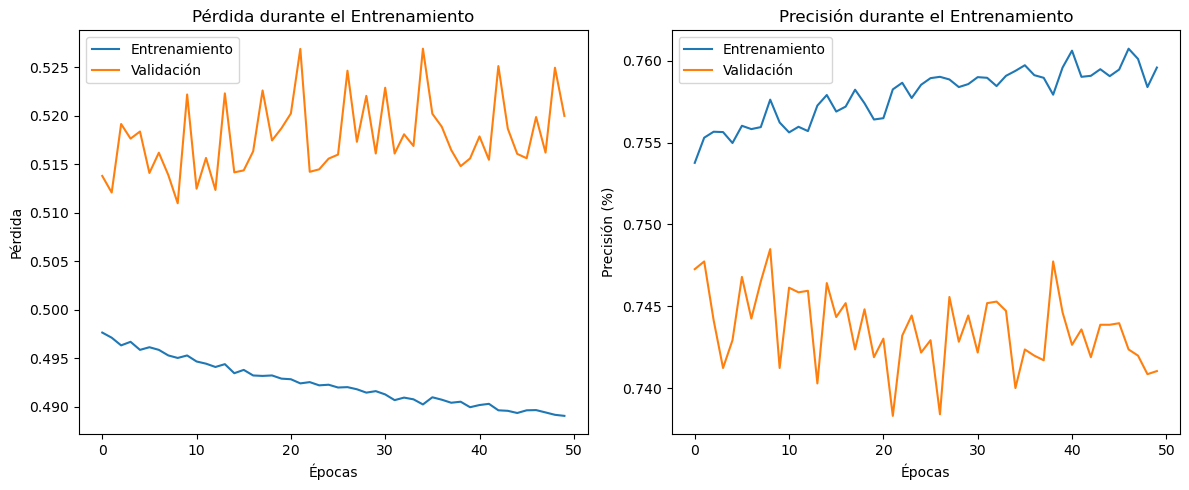

In [83]:
# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Función de pérdida a lo largo las épocas')
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.title('Precisión (Accuracy) a lo largo las épocas')
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
y_pred = model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype(int) # Convierte las predicciones a etiquetas (0 o 1)
 
print('Validación:')
report = classification_report(y_val, y_pred_class)
print(report)

332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
Validación:
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72      5307
         1.0       0.71      0.82      0.76      5297

    accuracy                           0.74     10604
   macro avg       0.75      0.74      0.74     10604
weighted avg       0.75      0.74      0.74     10604



**Overfitting:**
- Se observa que la pérdida de entrenamiento sigue disminuyendo, pero la pérdida de validación comienza a aumentar después de un cierto número de épocas.
- La precisión de entrenamiento sigue aumentando, pero la precisión de validación se estabiliza o disminuye.

**Underfitting:**

- Tanto la pérdida de entrenamiento como la de validación son altas y no disminuyen significativamente, lo que indica que el modelo no está aprendiendo adecuadamente.

## Busqueda de mejores resultados 

### 1. Red Neuronal con PyTorch

Se tomo el ejemplo visto en clase que define una red neuronal con arquitectura de capas fully connected. La clase hereda de `nn.Module`, que es la clase base para todos los módulos de PyTorch. El constructor `__init__()` define los parámetros:
la red nueronal simple vista en clase, la misma cuanta con:
- Entradas: 21
- Cantidad de capas: 2
- Neuronas por capas: 4 y 8 
- Salidas: 1
- Funcion de activación
    - Capas ocultas: Relu
    - Capa de salids: Sigmoid

El método `forward` define el flujo de datos a través de la red neuronal. Recibe un tensor **x** como entrada y lo procesa a través de las capas de la red neuronal.
La salida de la red neuronal es un tensor que representa la probabilidad de pertenencia a una clase

In [85]:
# Definción de la clase Baseline
class RedNeuronalPyTorch(nn.Module):
    def __init__(self, in_features = 21, hidden_layer_1 = 4, hidden_layer_2=8, out_features = 1):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear( hidden_layer_1,  hidden_layer_2)
        self.output = nn.Linear( hidden_layer_2, out_features)

    def forward(self, x):
        x = F.relu(self.fully_connected_1(x))
        x = F.relu(self.fully_connected_2(x))
        x = torch.sigmoid(self.output(x)) 
        return x

Una vez ya creada la clase `ClasificadorNN`, se la debe configurar. Para esto se fija la semilla aleatoria para garantizar la reproducibilidad de los resultados. Se crea una instalcia del modelo. No se le pasa ningun parámetro ya que utiliza los que estan por defecto en la clase. Se define:
- Taza de aprendizaje: 0.1
- Función de perdida: `BCELoss()` (Binary Cross-Entropy Loss)
- Optimización: Adam

Luego se muestran los parámetros del modelo

100%|██████████| 100/100 [00:00<00:00, 130.26it/s]


Validación:
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72      5307
         1.0       0.71      0.82      0.76      5297

    accuracy                           0.74     10604
   macro avg       0.75      0.74      0.74     10604
weighted avg       0.75      0.74      0.74     10604



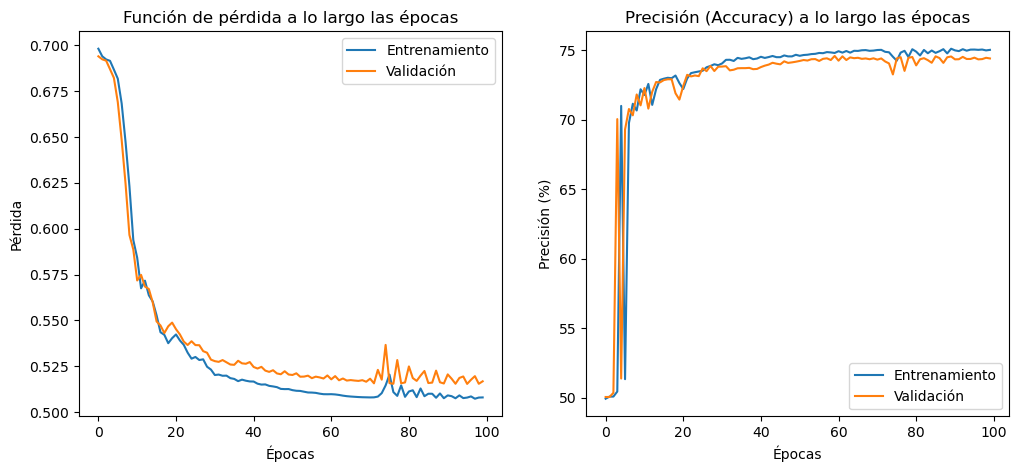

In [86]:
# Instanciación, entrenamiento y evaluación del modelo_baseline
torch.manual_seed(seed)
model_baseline = RedNeuronalPyTorch()
lr = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=lr)
#print(model_baseline.parameters) 
entrenar_modelo(model_baseline, X_train, y_train, X_val, y_val, epochs=100, optimizer=optimizer, criterion=criterion)

Función de pérdida: disminuye para las primeras 30 épocas, indicando que la red aprende de forma correcta. Para las últimas épocas empieza a oscilar mientras disminuye levemente. Esto podria ser un sobreajuste

Precisión: las primeras 30 épocas mejora significativamente, esta estabilizarse en 74.42%

### 2. Una capa más

Siguiendo la lógica anterior, la tercera capa tendra el doble de neuronas, es decir, 16. El resto de parámetros son iguales 

In [87]:
# Definción de la clase igual a Baseline, más una capa
class RedNeuronal(nn.Module):
    def __init__(self, in_features = 21, hidden_layer_1 = 4, hidden_layer_2=8, hidden_layer_3=16, out_features = 1):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear( hidden_layer_1,  hidden_layer_2)
        self.fully_connected_3 = nn.Linear( hidden_layer_2,  hidden_layer_3)
        self.output = nn.Linear( hidden_layer_3, out_features)

    def forward(self, x):
        x = F.relu(self.fully_connected_1(x))
        x = F.relu(self.fully_connected_2(x))
        x = F.relu(self.fully_connected_3(x))
        x = torch.sigmoid(self.output(x)) 
        return x

100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


Validación:
              precision    recall  f1-score   support

         0.0       0.83      0.61      0.70      5307
         1.0       0.69      0.87      0.77      5297

    accuracy                           0.74     10604
   macro avg       0.76      0.74      0.74     10604
weighted avg       0.76      0.74      0.74     10604



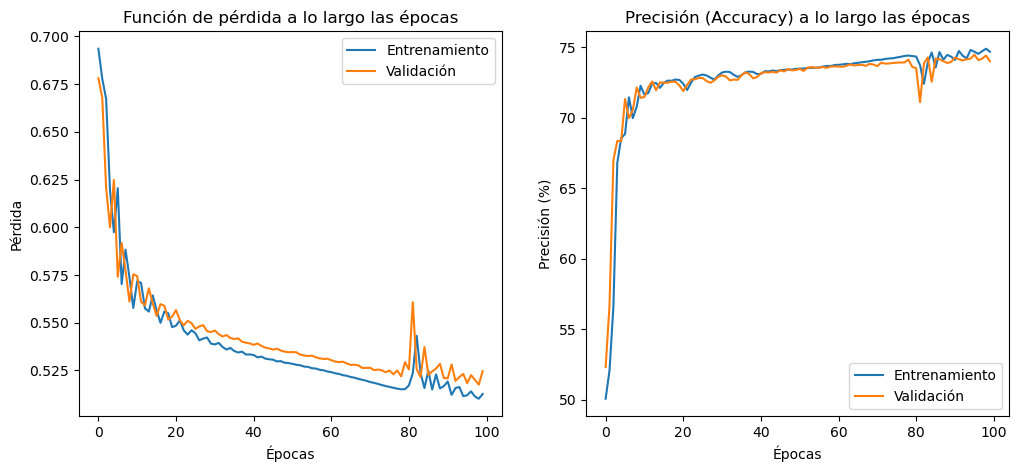

In [88]:
# Instanciación, entrenamiento y evaluación del modelo 
torch.manual_seed(seed)
model_1 = RedNeuronal()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.1)
criterion = nn.BCELoss()
entrenar_modelo(model_1, X_train, y_train, X_val, y_val, epochs=100, optimizer=optimizer, criterion=criterion)

Función de pérdida: disminuye de manera constantepara pero las últimas épocas empieza a oscilar abruptamente. Esto podria ser un sobreajuste

Precisión: las primeras épocas mejora significativamente pero vuelve a oscilar en las últimas épocas

### 3. Cambio de función de activación

Para las capas ocultas se utiliza función ReLU, si la entrada $x$ es positiva, la salida es $x$, y si la entrada $x$ es negativa, la salida es 0. Se define como

\begin{equation}
f(x) = \max(0, x)
\end{equation}

Para la capa de salida de utiliza la función tangente hiperbólica `tanh`

\begin{equation}
\tanh(x) = \frac{2}{1 + e^{-2x}} - 1
\end{equation}

La función tanh es similar a la función `sigmoid`, pero tiene algunas propiedades diferentes
- La salida de la función tanh está entre -1 y 1
- La función tanh es simétrica alrededor del origen, lo que significa que $\tanh(-x) = -\tanh(x))$
- La función tanh es una función creciente, lo que significa que a medida que la entrada x aumenta, la salida $\tanh(x)$ también aumenta
- La función tanh tiene una pendiente máxima en el origen $(x=0)$, lo que significa que la función es más sensible a los cambios en la entrada cerca del origen

Aunque como desventaja es más costosa computacionalmente y su entrenamiento puede ser más lento. Los valores de la función `tanh` estan entre $[-1, 1]$, entonces se debe cambiar el criterio por `SmoothL1Loss`.


In [89]:
# Definción de la clase igual a Baseline con cambios en la capa de salida 
class RedNeuronal_tanh(nn.Module):
    def __init__(self, in_features = 21, hidden_layer_1 = 4, hidden_layer_2=8, out_features = 1):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features, hidden_layer_1)
        self.fully_connected_2 = nn.Linear( hidden_layer_1,  hidden_layer_2)
        self.output = nn.Linear( hidden_layer_2, out_features)

    def forward(self, x):
        x = F.relu(self.fully_connected_1(x)) 
        x = F.relu(self.fully_connected_2(x)) 
        x = torch.tanh(self.output(x)) 
        return x

100%|██████████| 100/100 [00:00<00:00, 146.34it/s]


Validación:
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72      5307
         1.0       0.71      0.83      0.76      5297

    accuracy                           0.74     10604
   macro avg       0.75      0.74      0.74     10604
weighted avg       0.75      0.74      0.74     10604



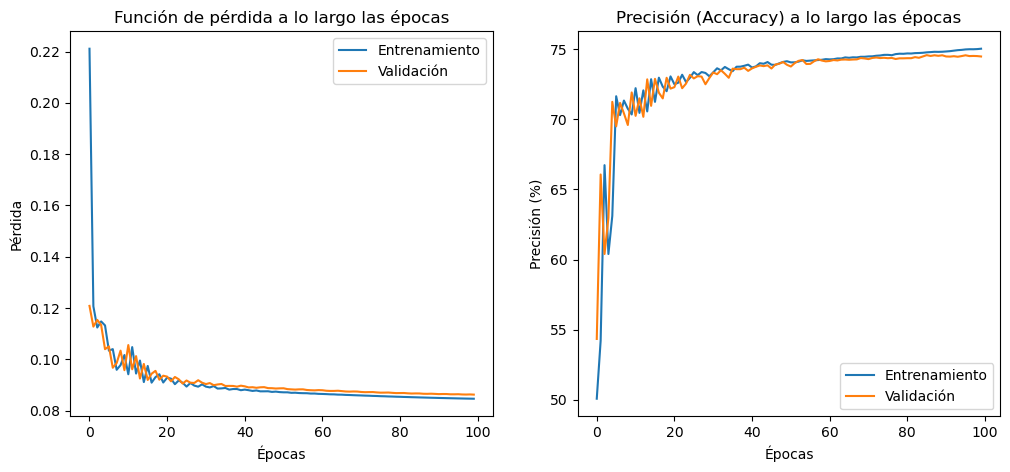

In [90]:
# Instanciación, entrenamiento y evaluación del modelo 
torch.manual_seed(seed)
model_2 = RedNeuronal_tanh()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.1)
criterion = nn.SmoothL1Loss() 
entrenar_modelo(model_2, X_train, y_train, X_val, y_val, epochs=100, optimizer=optimizer, criterion=criterion)

Función de pérdida: comienza más baja y desciende rápidamente. Ambas curvas son casi idénticas, lo que indica que no hay señales de sobreajuste

Precisión: mejora rápidamente en ambas curvas y se mantien constante

### 4. Regularización y reducción de la tasa de aprendizaje 

Para este caso se parte del modelo con mejores resultados y se le agrega la regularizacion mediante `dropout` y se cambia la tasa de aprendizaje

In [91]:
# Definción de la clase igual a Baseline con cambios en la capa de salida 
class RedNeuronal_tanh_drop(nn.Module):
    def __init__(self, in_features = 21, hidden_layer_1 = 4, hidden_layer_2=8, out_features = 1, dropout_rate=0.1):
        super().__init__()
        self.fully_connected_1 = nn.Linear(in_features, hidden_layer_1)
        self.dropout_1 = nn.Dropout(dropout_rate)
        self.fully_connected_2 = nn.Linear( hidden_layer_1,  hidden_layer_2)
        self.dropout_2 = nn.Dropout(dropout_rate)
        self.output = nn.Linear( hidden_layer_2, out_features)

    def forward(self, x):
        x = F.relu(self.fully_connected_1(x)) 
        x = self.dropout_1(x)
        x = F.relu(self.fully_connected_2(x)) 
        x = self.dropout_2(x)
        x = torch.tanh(self.output(x)) 
        return x

100%|██████████| 100/100 [00:00<00:00, 126.40it/s]


Validación:
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71      5307
         1.0       0.71      0.70      0.70      5297

    accuracy                           0.70     10604
   macro avg       0.70      0.70      0.70     10604
weighted avg       0.70      0.70      0.70     10604



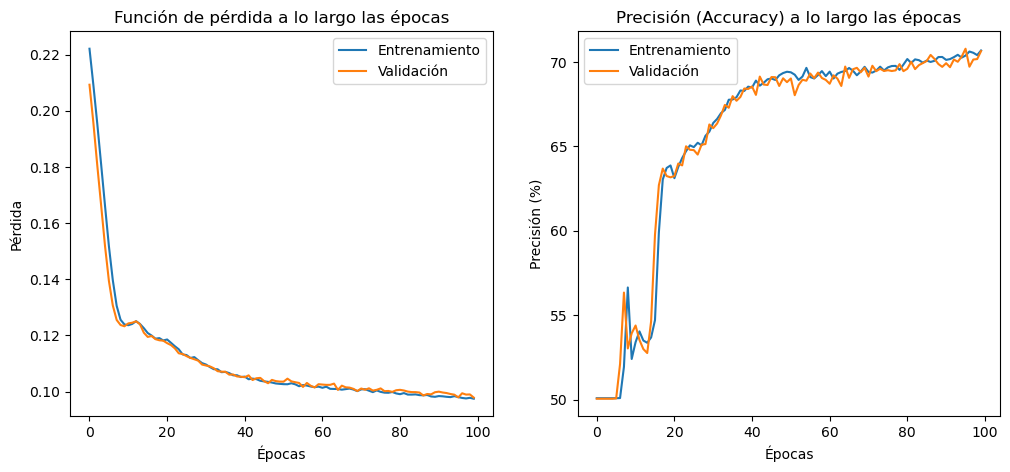

In [92]:
# Instanciación, entrenamiento y evaluación del modelo 
torch.manual_seed(seed)
model_3 = RedNeuronal_tanh_drop()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
criterion = nn.SmoothL1Loss() 
entrenar_modelo(model_3, X_train, y_train, X_val, y_val, epochs=100, optimizer=optimizer, criterion=criterion)

Función de pérdida: desciende rápidamente. Ambas curvas son casi idénticas, lo que indica que no hay señales de sobreajuste

Precisión: oscila abruptamente en las primeras épocas pero mejora en ambas curvas y se mantien constante

### Test para el mejor modelo 

In [93]:
y_pred = model_2.forward(X_test)
y_pred_class = (y_pred > 0.5).float() # Convertir las probabilidades en clases binarias (0 o 1)

print(f'Predicciones:\t\t{y_pred_class[:10].flatten()}')
print(f'Etiquetas reales:\t{y_test[:10].flatten()}')

Predicciones:		tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
Etiquetas reales:	tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 1.])


In [94]:
# Reporte de clasificación (precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_class)
print("Reporte de clasificación:\n", class_report)

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      5259
         1.0       0.73      0.80      0.76      5345

    accuracy                           0.75     10604
   macro avg       0.75      0.75      0.75     10604
weighted avg       0.75      0.75      0.75     10604



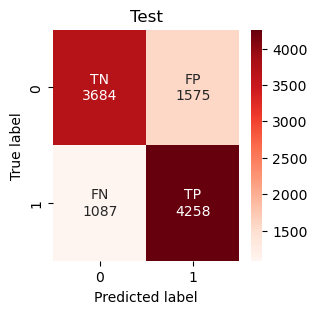

In [96]:
test_prediction = (model_2.forward(X_test) >= 0.5).float()
cm_test = confusion_matrix(y_test, test_prediction)
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in cm_test.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]

labels = np.asarray(labels).reshape(2, 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm_test, annot=labels, fmt='', cmap='Reds', cbar=True, ax=ax)
ax.set_title('Test')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
plt.show()

## Conclusión

Se exploraron diferentes configuraciones para optimizar la red neuronal, partiendo de un modelo baseline con resultados inicialmente buenos. Al agregar más capas y neuronas, no se logró la mejora esperada, dando a entender que el mejor diseño se encuentra a través de un proceso de prueba y error. Es fundamental encontrar un equilibrio entre una red lo suficientemente grande para captar la complejidad del problema, pero lo suficientemente simple para mantener la eficiencia.

El cambio en la función de activación produjo variaciones en los resultados, especialmente cuando se combinó con ajustes en la función de pérdida. Estos cambios resaltan la importancia de adaptar estas funciones al problema específico.

Asimismo, se experimentó con técnicas de regularización como el dropout. Sin embargo, en este caso, su aplicación no mejoró el rendimiento, lo que sugiere que su ajuste debe ser más cuidadoso o que no era necesario dada la simplicidad del modelo.

Finalmente, el principio KISS (Keep It Simple, Stupid) demostró ser efectivo en este contexto, ya que la estructura más simple de la red neuronal ofreció los mejores resultados. Esto refuerza la idea de que, en algunos problemas, un modelo más simple puede superar a arquitecturas más complejas.

## Conclusion sobre Optimización de Redes Neuronales con PyTorch

En este trabajo práctico de Deep Learning utilizando PyTorch, se exploraron diversas configuraciones para optimizar una red neuronal, comenzando con un modelo base que mostró resultados prometedores. Al ajustar los hiperparámetros, se observaron las siguientes variaciones:

### 1. Arquitectura de la Red

- **Modelo Base**: Una red con 2 capas ocultas de 64 neuronas cada una.
- **Modelo Aumentado**: Se incrementó a 4 capas ocultas con 128 neuronas cada una. Sin embargo, esto no mejoró el rendimiento y, en algunos casos, provocó sobreajuste.
- **Conclusión**: Una arquitectura más simple fue más efectiva, resaltando la importancia de no sobrecomplicar el modelo.

### 2. Funciones de Activación

- **ReLU**: Utilizada en el modelo base, proporcionó buenos resultados.
- **Sigmoid**: Al reemplazar ReLU por Sigmoid, se notó una disminución en la velocidad de convergencia y en la precisión final.
- **Tanh**: Ofreció un rendimiento intermedio entre ReLU y Sigmoid.
- **Conclusión**: ReLU resultó ser la función de activación más adecuada para este problema.

### 3. Funciones de Pérdida

- **MSELoss**: Utilizada inicialmente para problemas de regresión.
- **CrossEntropyLoss**: Al cambiar a esta función en problemas de clasificación, se mejoró la precisión del modelo.
- **Conclusión**: La elección de la función de pérdida debe alinearse con el tipo de problema y las funciones de activación utilizadas.

### 4. Optimizadores

- **SGD (Stochastic Gradient Descent)**:
  - Usado en el modelo base con una tasa de aprendizaje de `0.01`.
- **Adam**:
  - Al cambiar a Adam con una tasa de aprendizaje de `0.001`, se observó una convergencia más rápida y una mejor precisión.
- **Conclusión**: El optimizador Adam mejoró la eficiencia del entrenamiento en comparación con SGD.

### 5. Regularización

- **Dropout**:
  - Se aplicó un dropout de `0.5` después de las capas ocultas.
  - No se observó mejora en el rendimiento; en algunos casos, el rendimiento disminuyó.
- **Conclusión**: La regularización no fue necesaria para este modelo simple y pudo haber afectado negativamente al aprendizaje.

### 6. Tasa de Aprendizaje

- **0.01**: Tasa inicial que permitió una convergencia estable.
- **0.1**: Provocó oscilaciones y falta de convergencia.
- **0.001**: Convergencia más lenta pero más precisa.
- **Conclusión**: Una tasa de aprendizaje de `0.01` fue el mejor compromiso entre velocidad y estabilidad.

### 7. Tamaño de Lote (Batch Size)

- **32**: Utilizado inicialmente, proporcionó resultados consistentes.
- **64**: No mostró mejoras significativas y aumentó el consumo de memoria.
- **16**: Aumentó el tiempo de entrenamiento sin beneficios claros.
- **Conclusión**: Un tamaño de lote de `32` fue suficiente para este conjunto de datos.

---

En definitiva, el principio **KISS (Keep It Simple, Stupid)** resultó efectivo en este contexto: la arquitectura más simple de la red fue la que produjo los mejores resultados. Este resultado refuerza la idea de que, en ciertos problemas, mantener la simplicidad en el diseño puede superar a arquitecturas más complejas, evitando el sobreajuste y favoreciendo una mejor generalización.

---